In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Ab hier Loss function(dice loss)

In [4]:
class loss():
  #
  def dice_loss(pred, target, smooth = 1.):
      pred = pred.contiguous()
      target = target.contiguous()

      intersection = (pred * target).sum(dim=2).sum(dim=2)

      loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

      return loss.mean()

## Ab hier Model Aufbau

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchvision.models import resnet18, ResNet18_Weights
import math
from torchvision import transforms
import time
from matplotlib import pyplot as plt
import numpy as np

def convrelu(in_channels, out_channels, kernel, padding):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        torch.nn.ReLU(inplace=True),
    )

from collections import defaultdict
import torch.nn.functional as F


def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.9):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


class ResNetUNet(torch.nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())
        #self.hidden_size1 = 64
        #self.hidden_size2
        #self.hidden_size3
        #self.hidden_size4

        self.layer0 = torch.nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = torch.nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = torch.nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)#skip connections
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out



In [7]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.load('/content/drive/MyDrive/model/model95videos.pth')

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

### Video einlesen und model testen

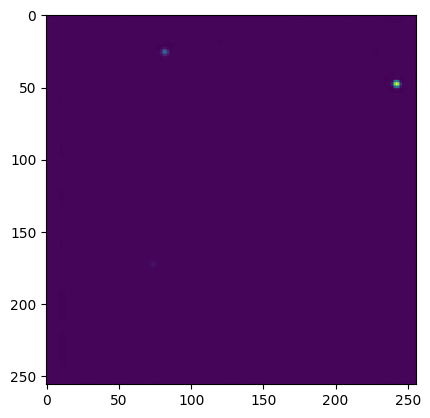

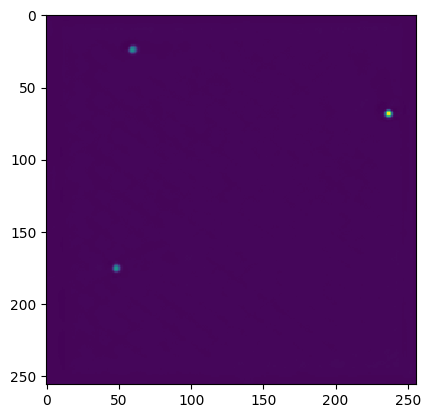

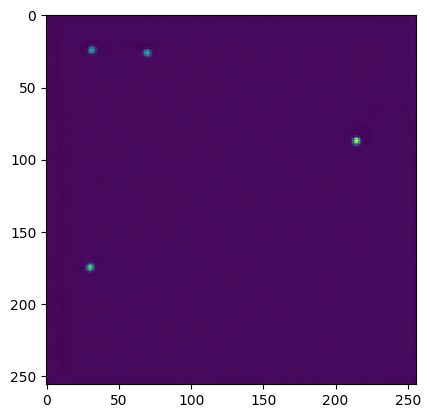

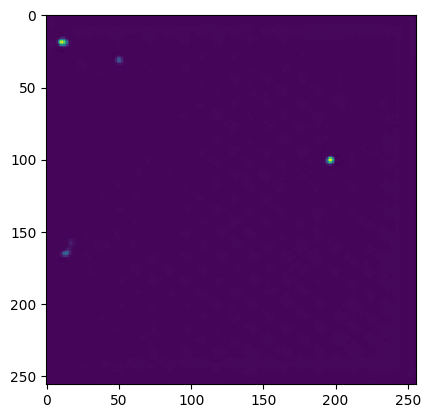

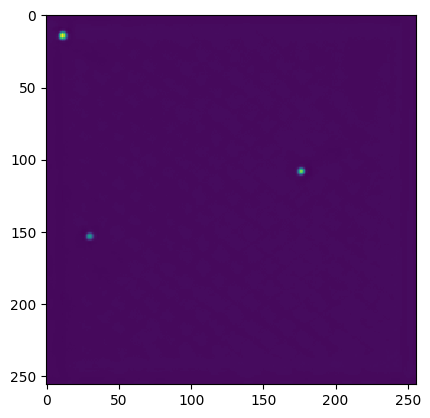

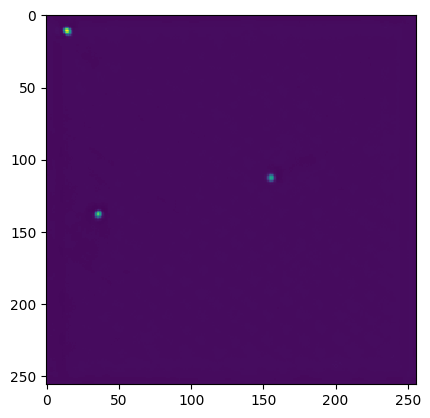

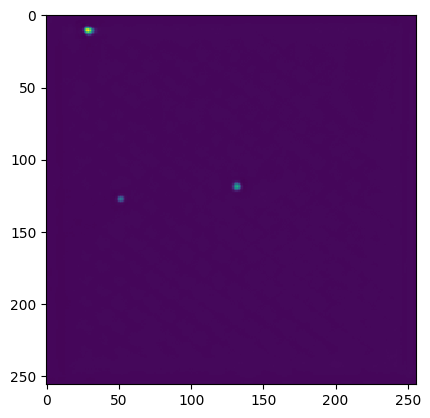

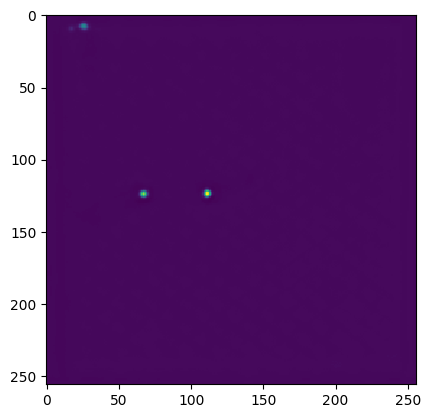

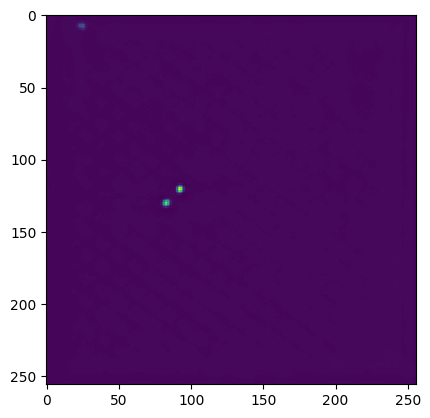

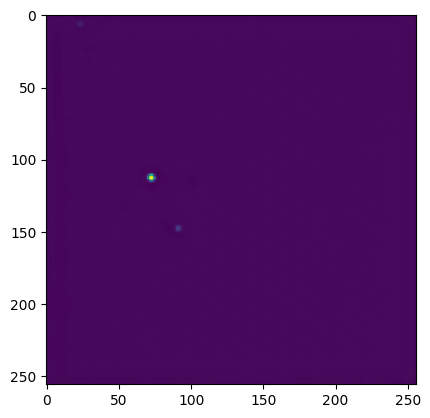

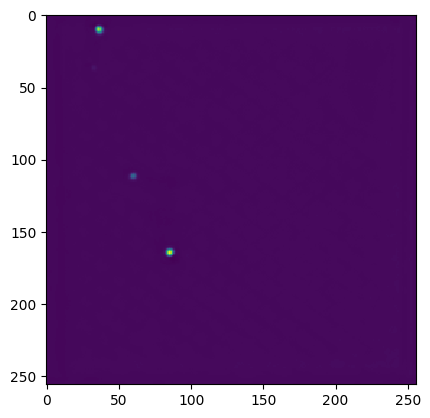

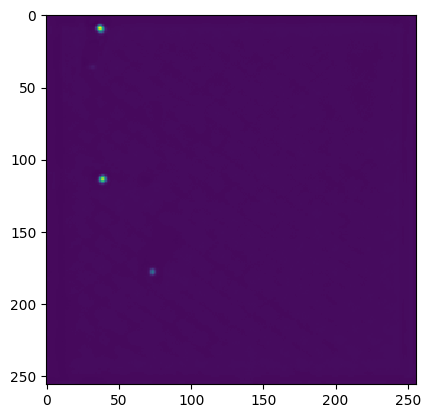

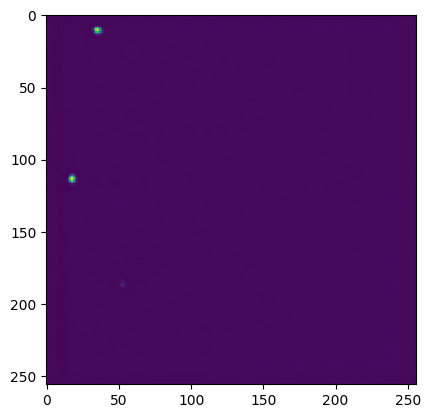

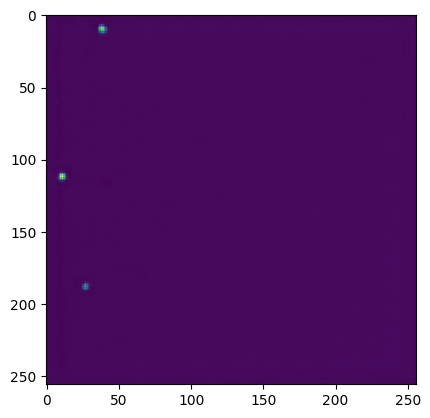

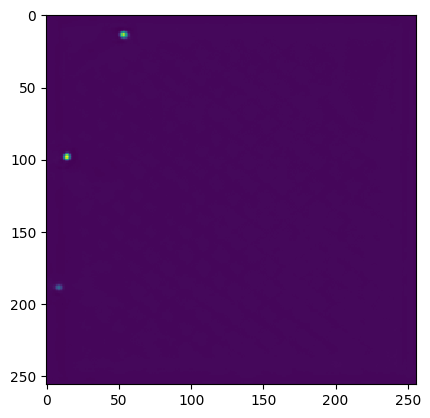

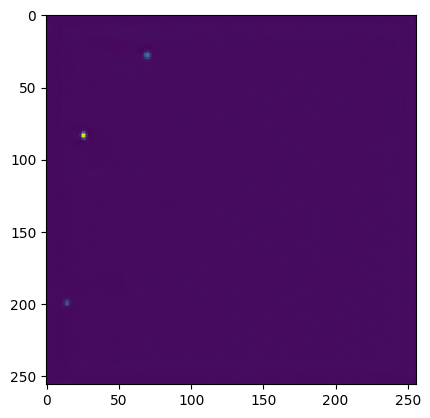

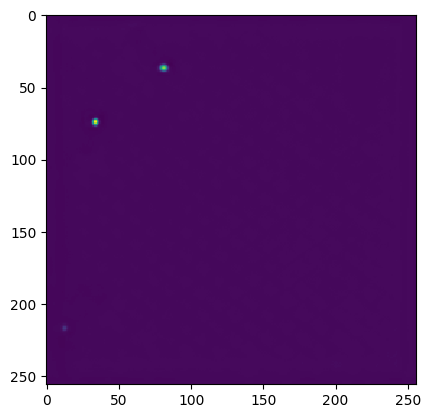

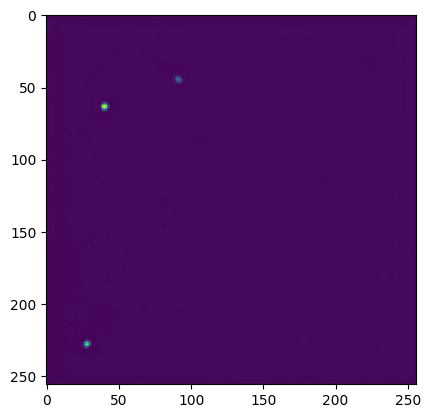

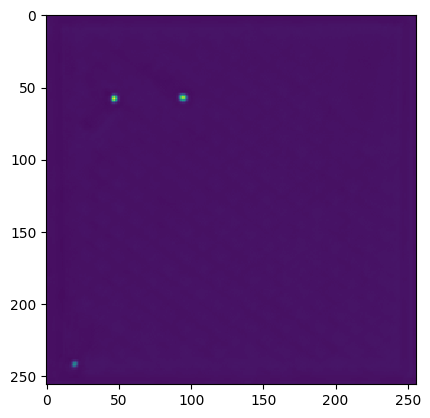

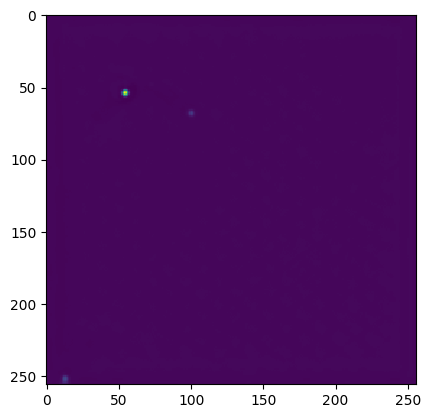

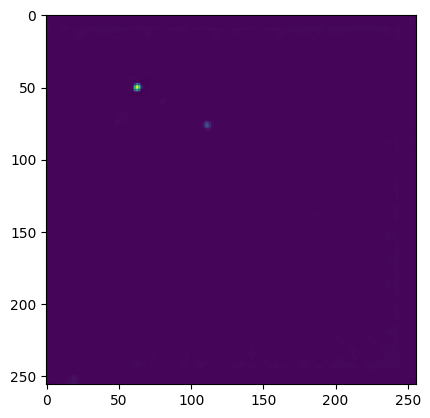

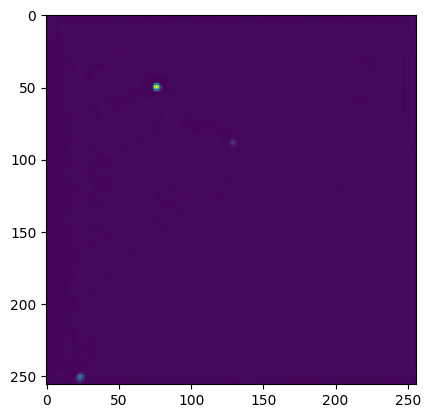

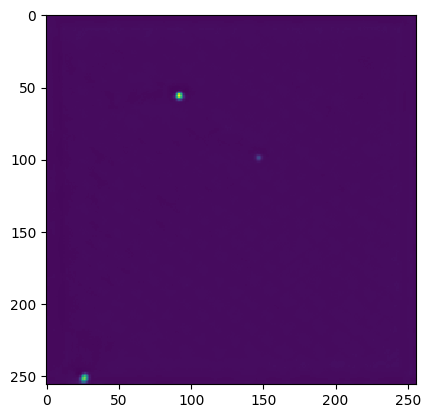

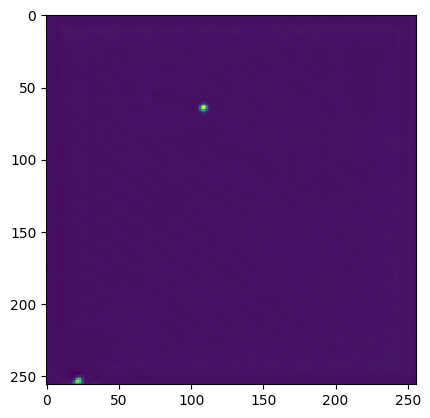

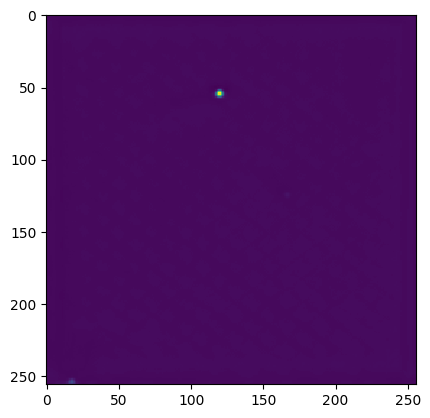

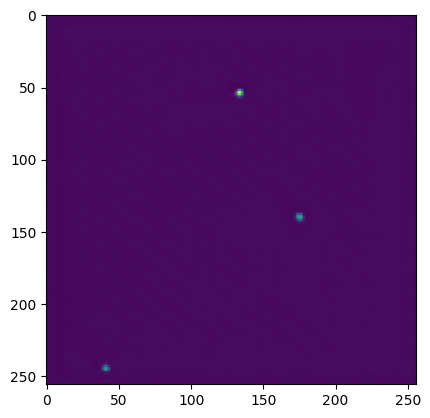

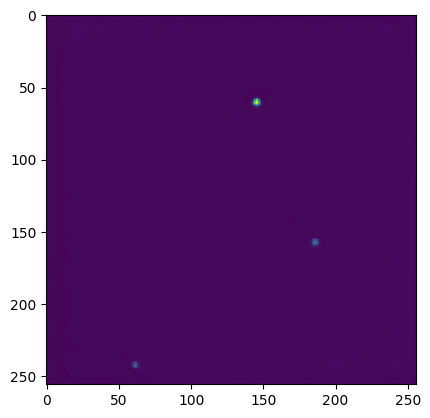

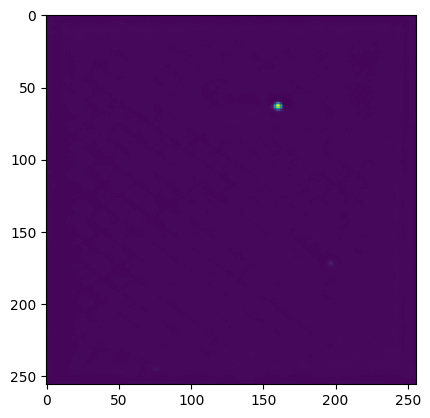

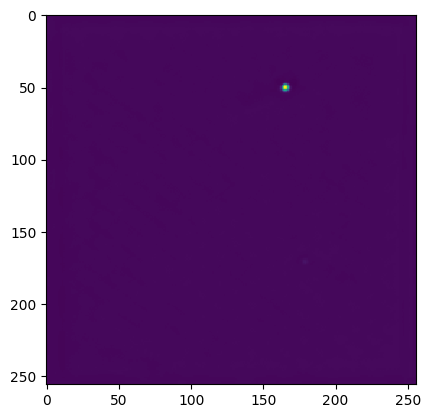

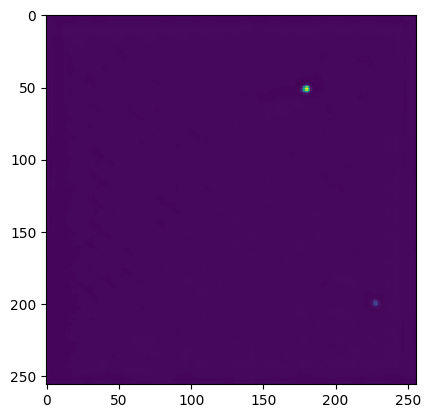

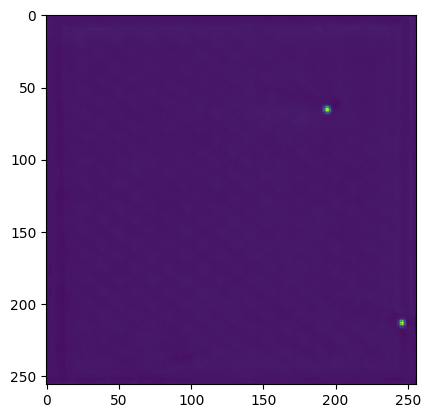

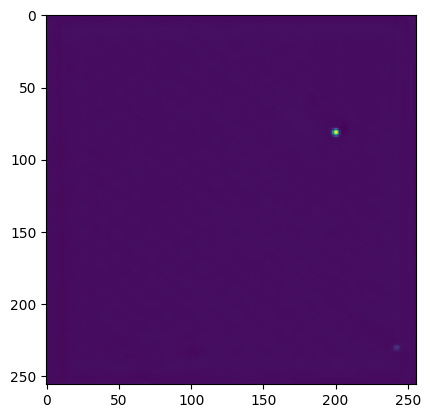

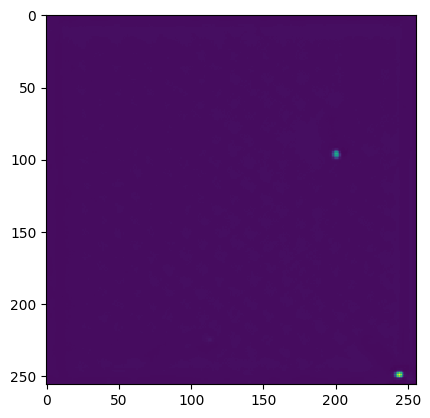

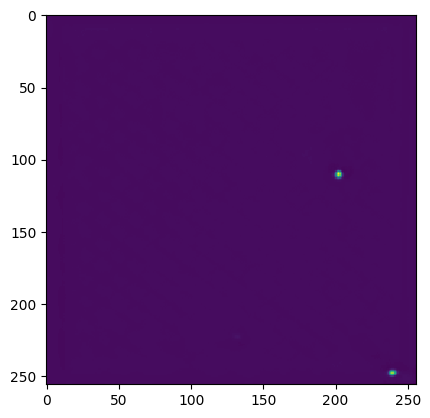

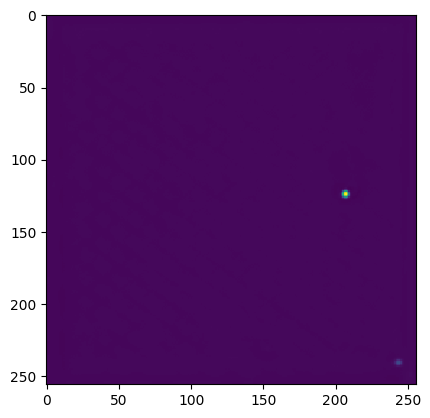

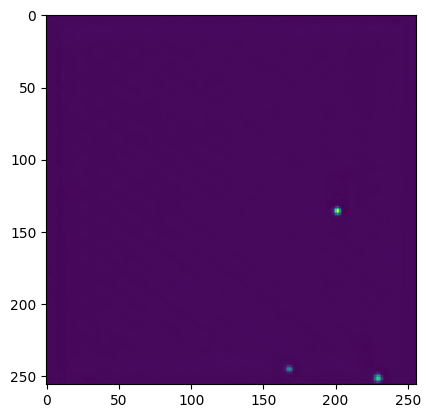

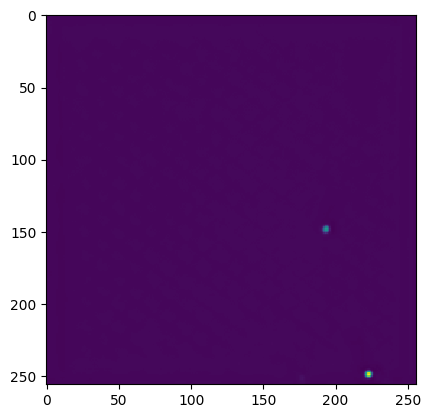

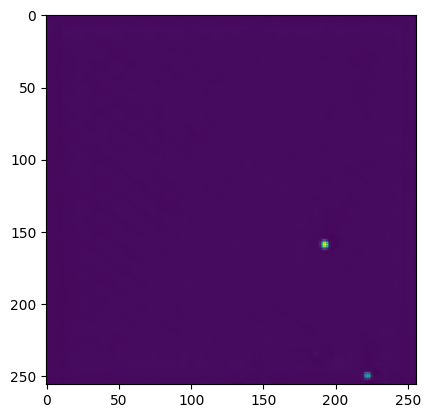

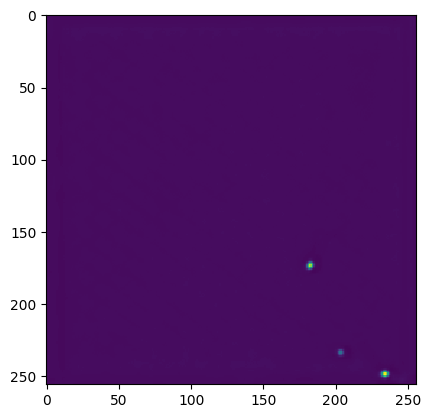

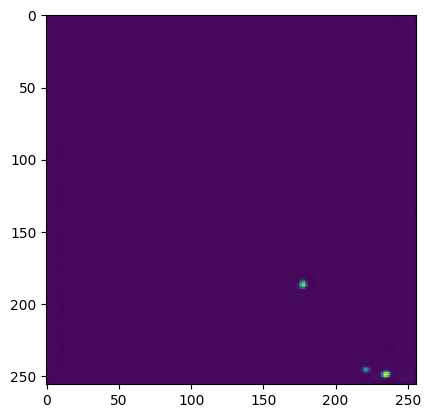

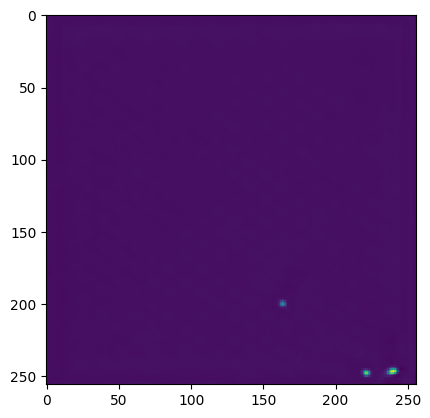

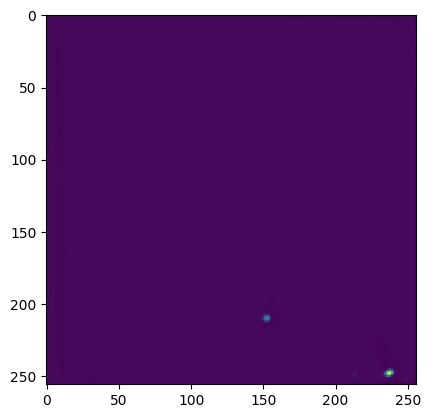

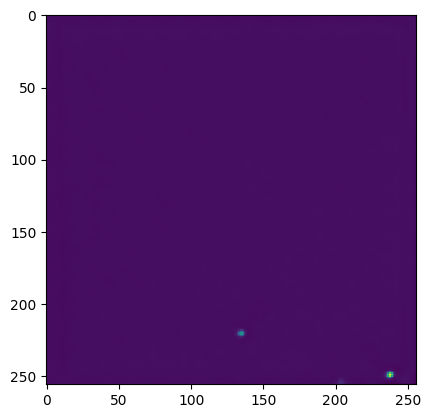

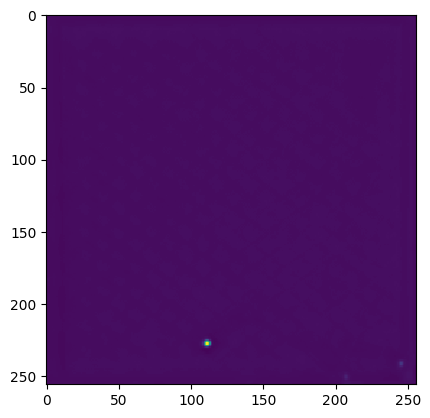

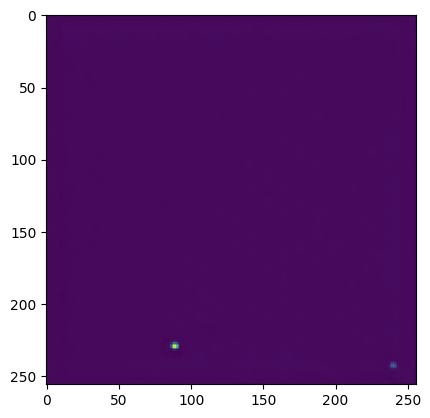

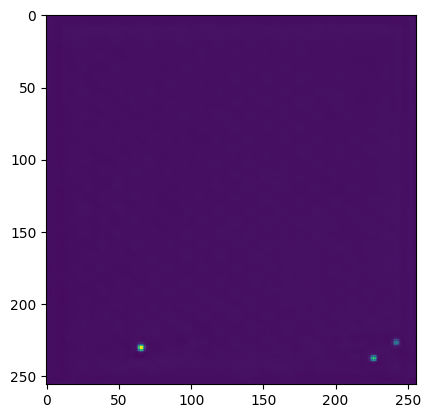

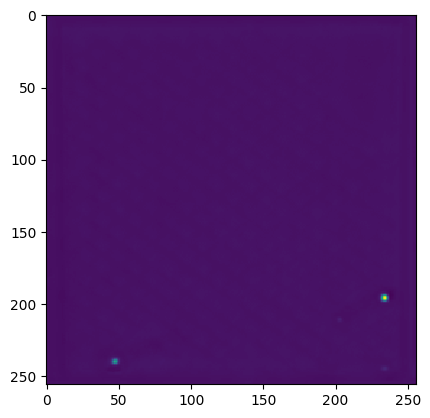

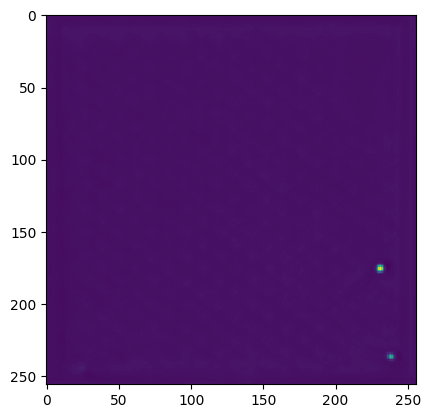

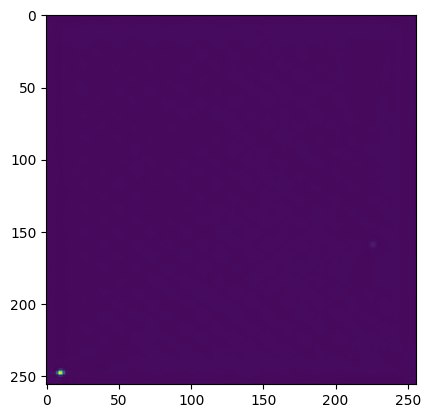

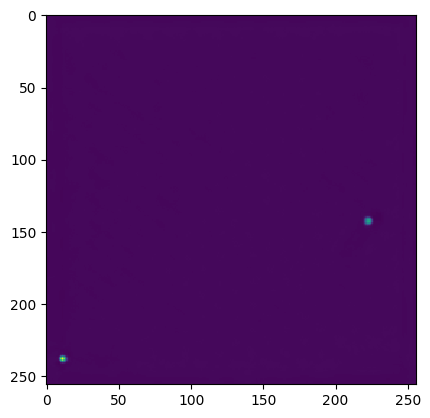

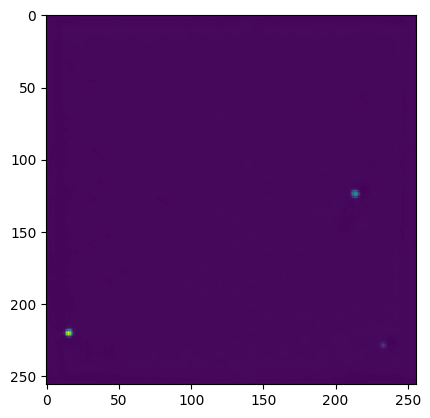

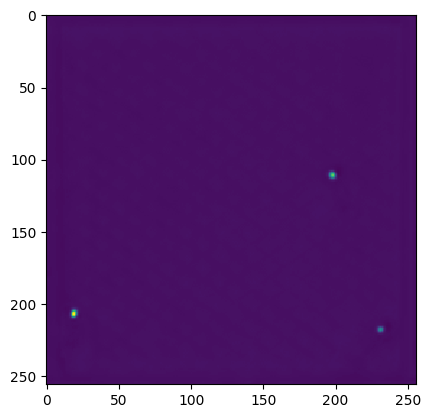

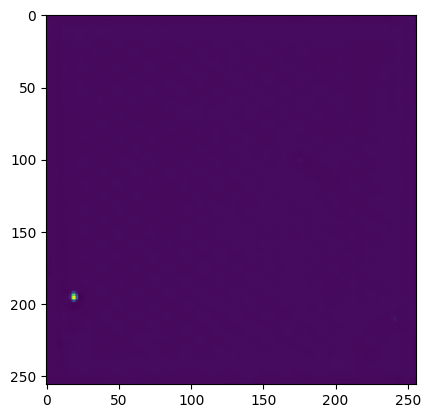

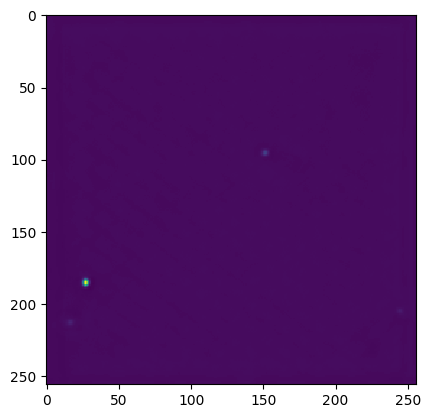

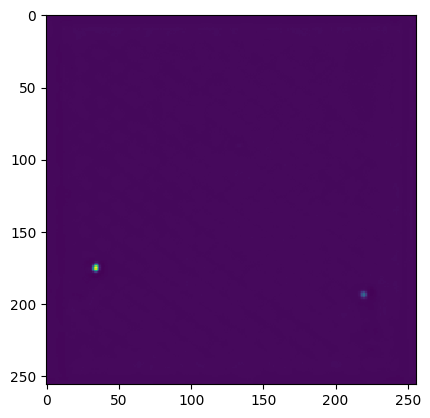

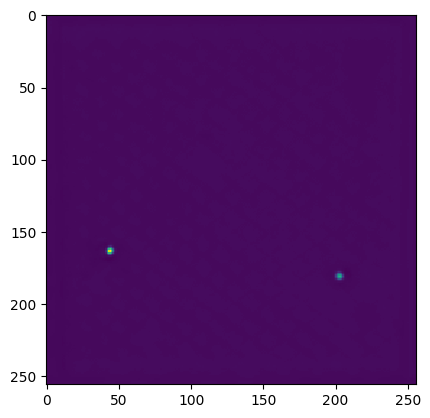

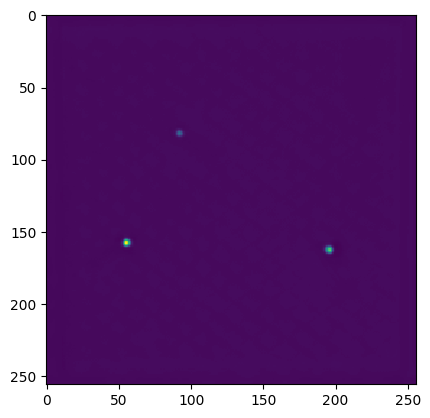

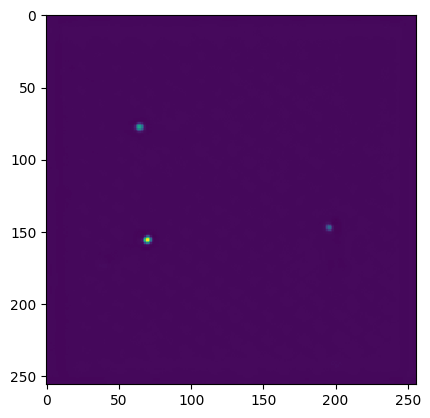

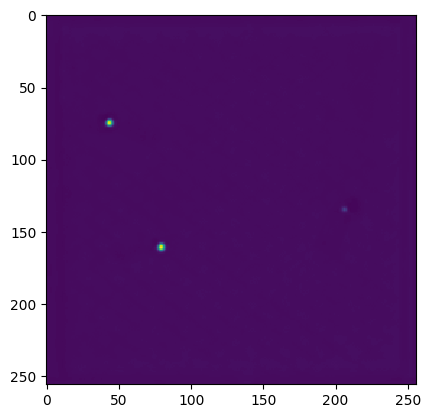

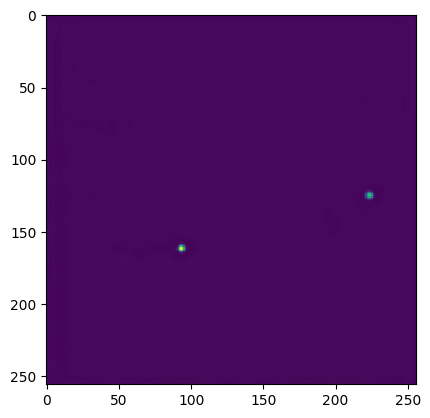

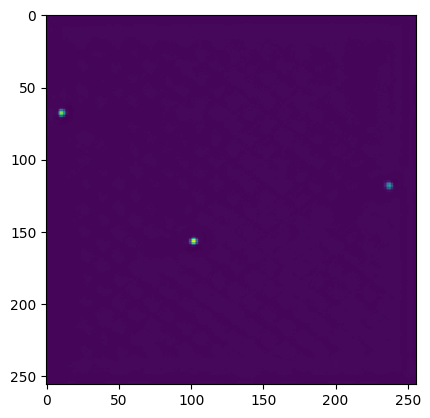

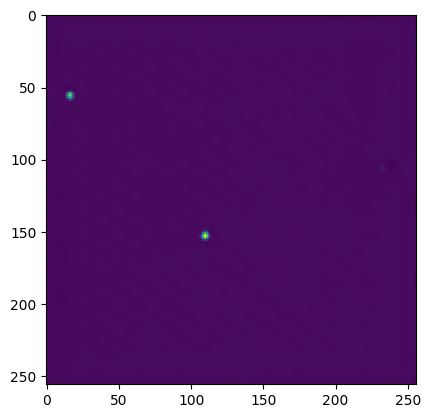

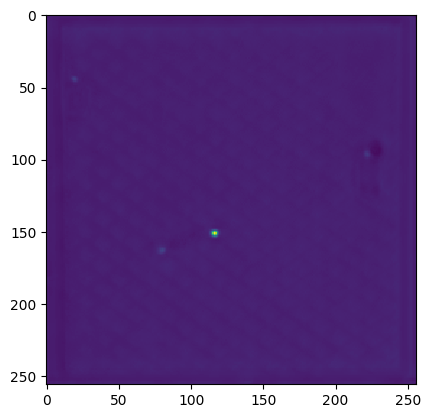

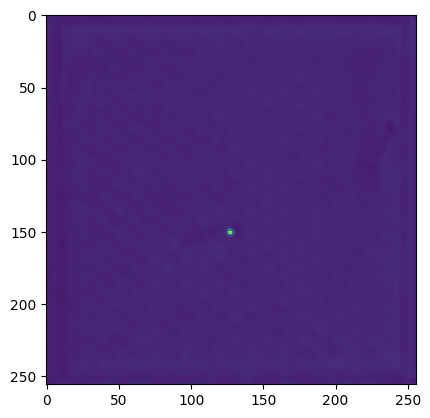

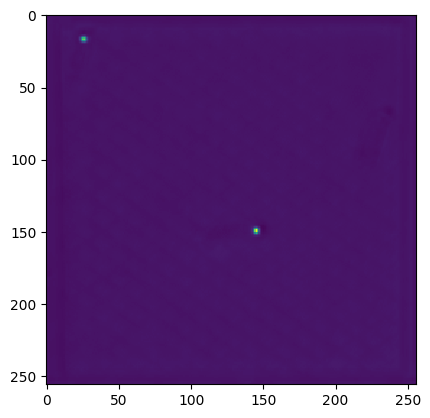

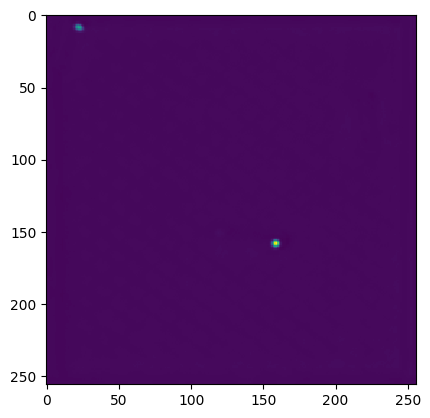

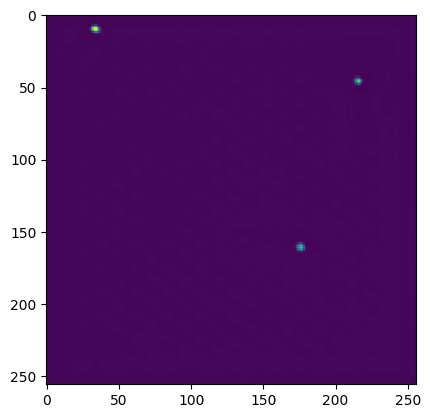

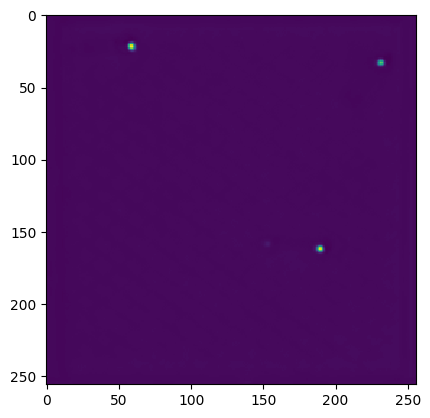

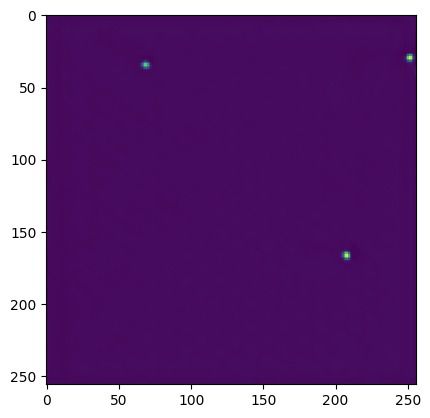

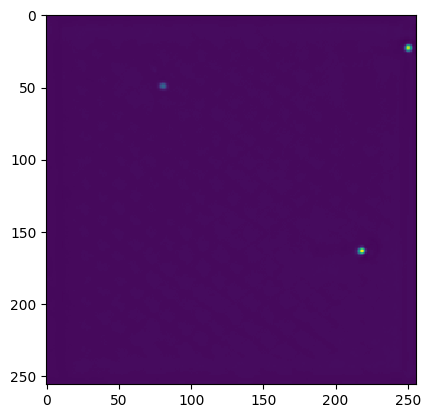

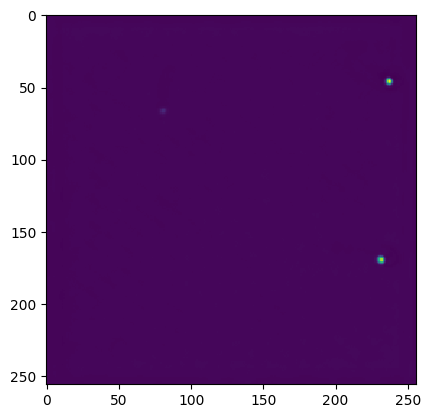

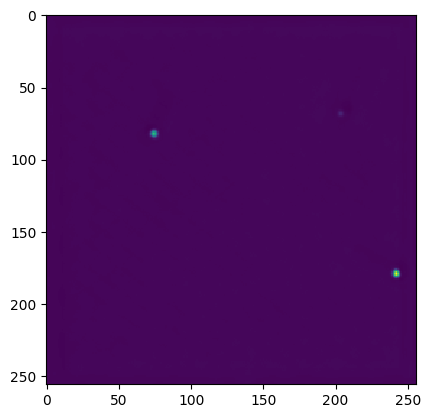

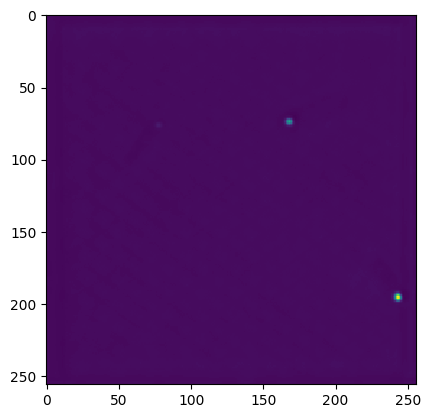

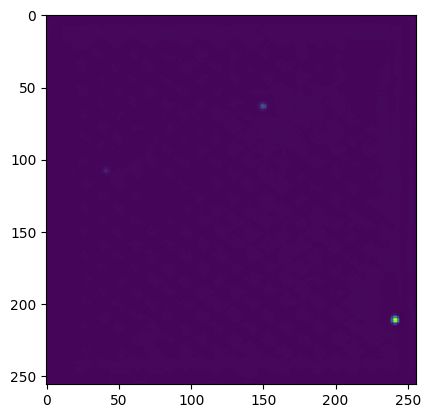

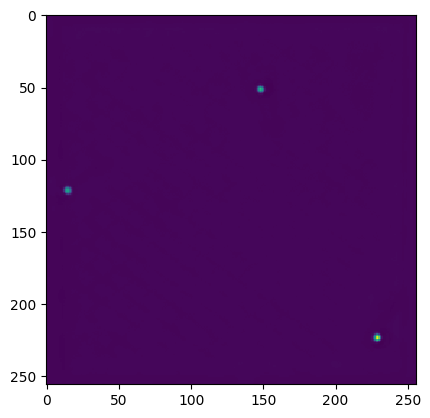

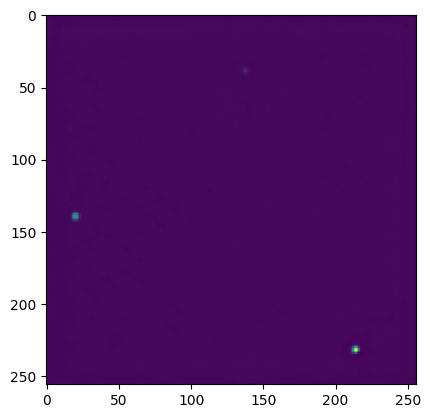

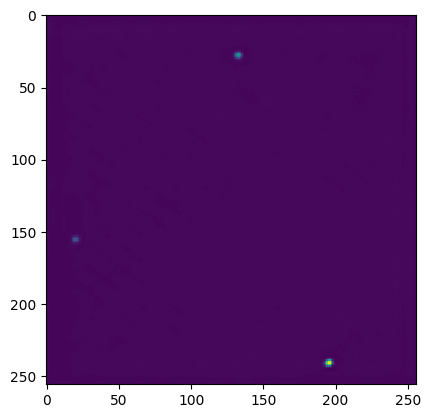

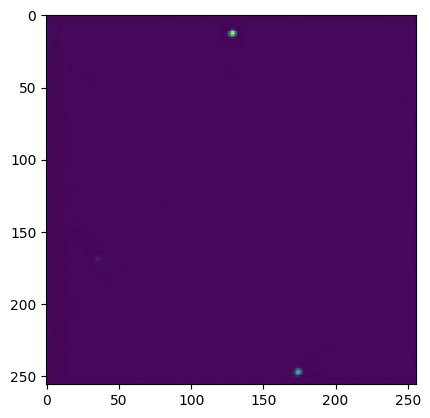

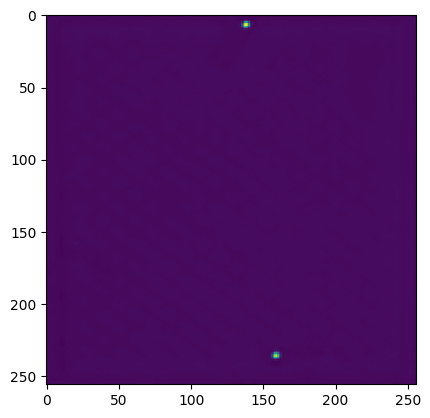

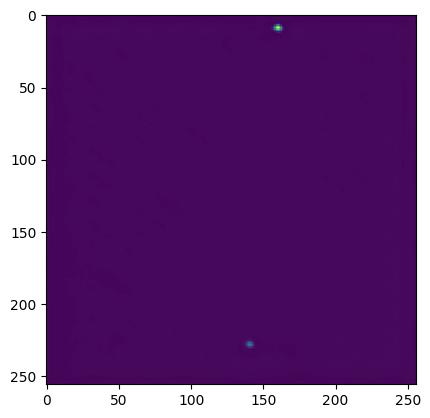

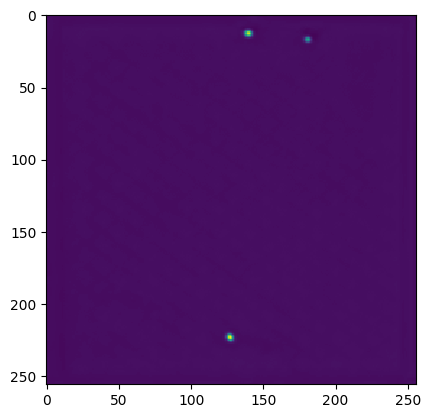

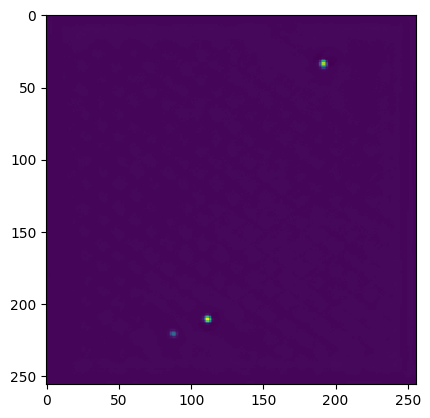

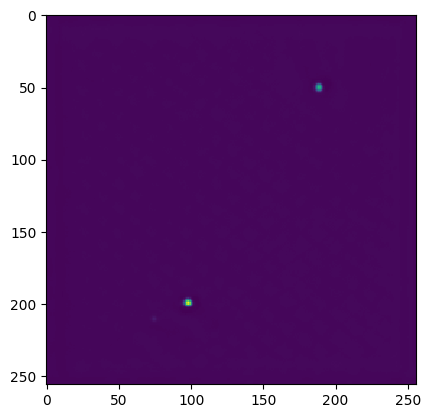

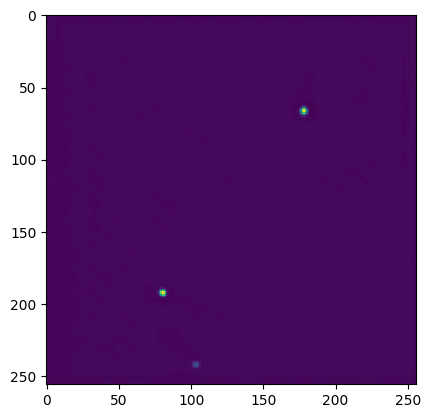

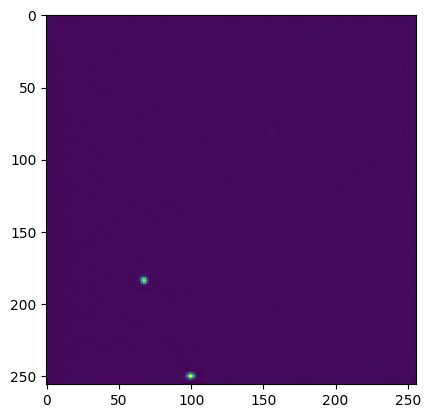

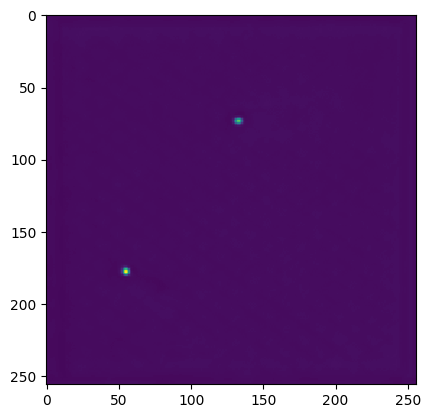

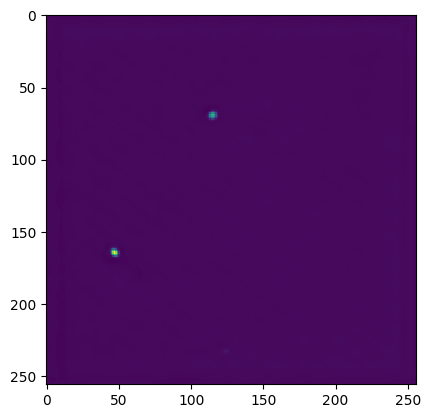

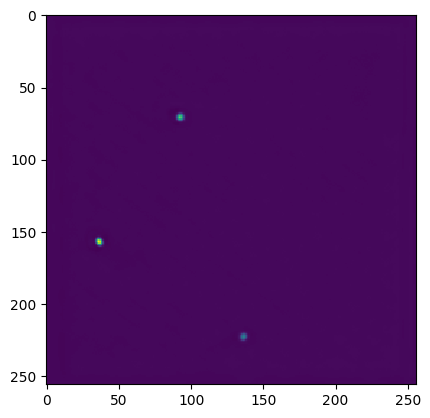

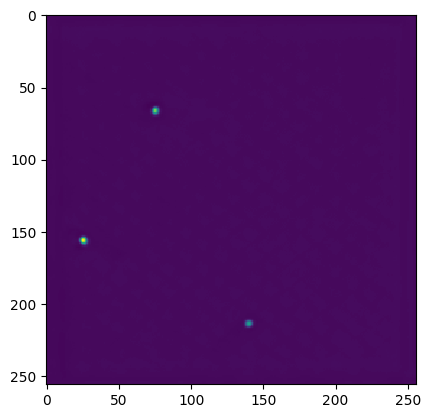

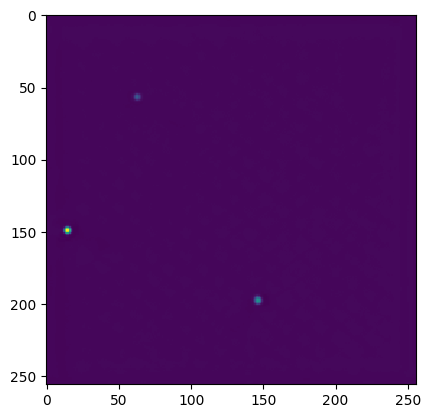

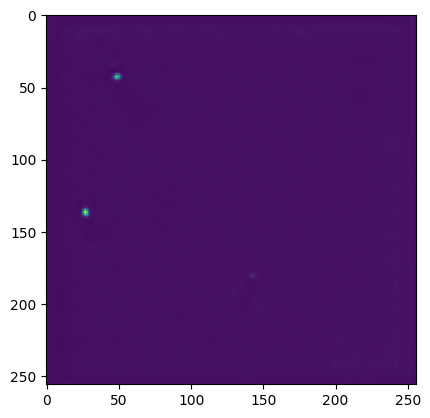

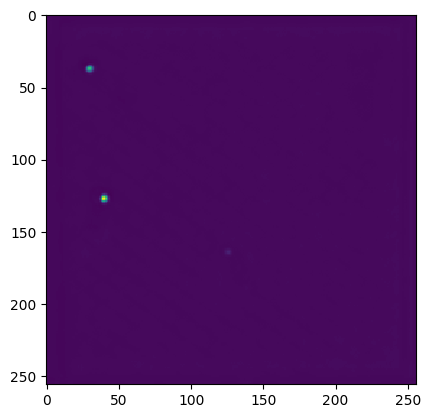

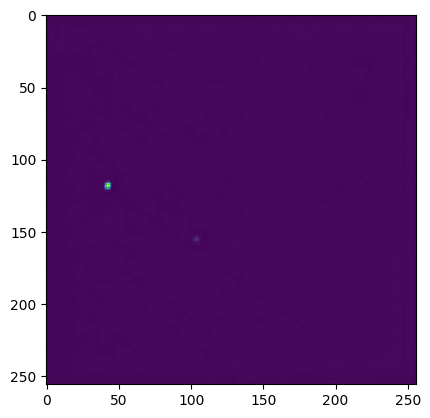

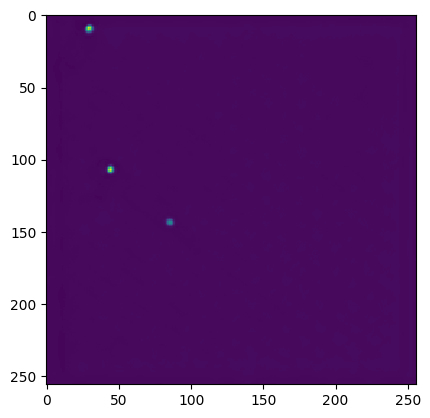

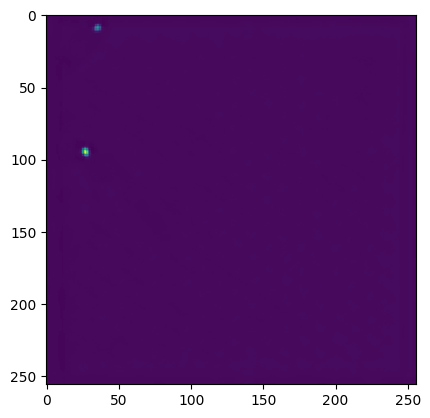

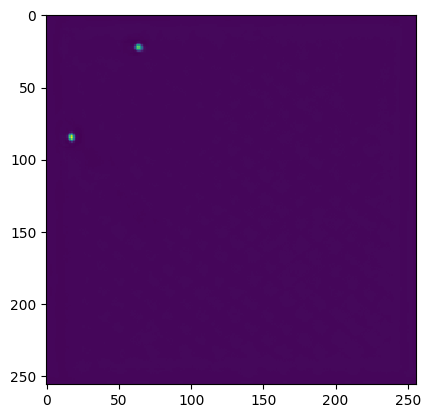

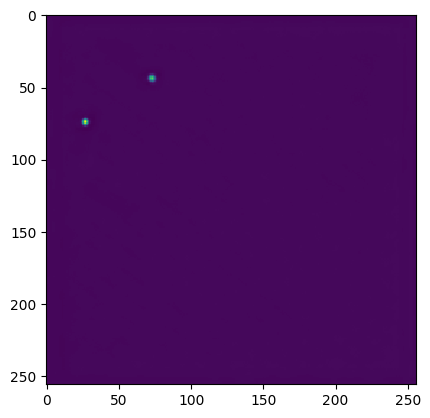

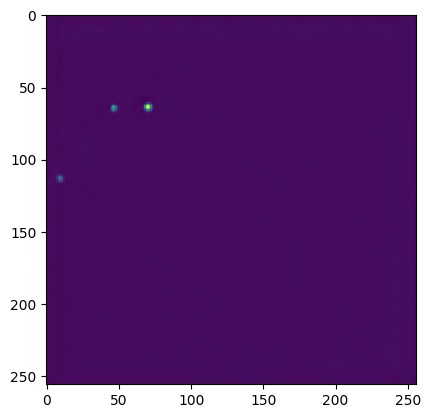

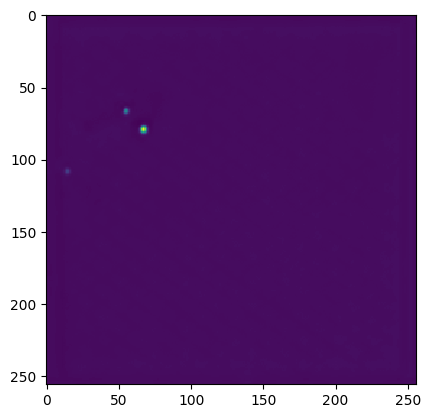

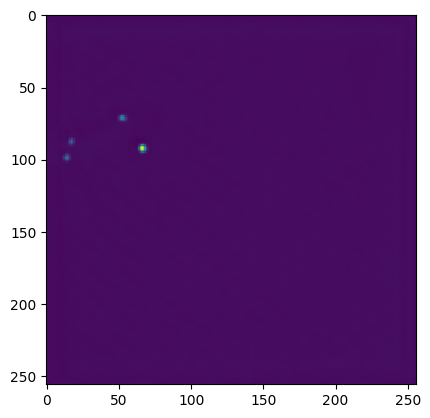

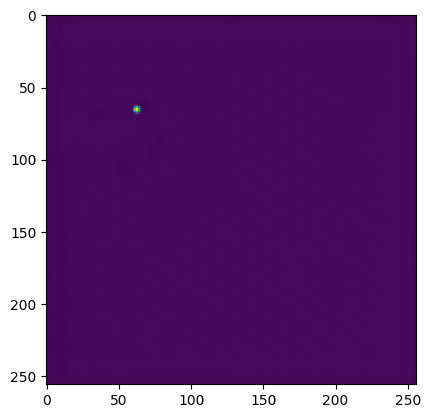

101


In [45]:
import torch
import time
from torch.utils.data import Dataset
import pickle
import numpy as np
import cv2
from matplotlib import pyplot as plt
cap = cv2.VideoCapture("/content/drive/MyDrive/Traco_Hiwi/test001.mp4")
frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fc = 0
ret = True
prediction = []
transform = transforms.Compose([transforms.ToTensor()])
frameWidth,frameHeight,channels =0,0,0
while (fc < frameCount and ret):
  #take frame
  ret, buf = cap.read()
  # convert to RGB
  im_rgb = cv2.cvtColor(buf, cv2.COLOR_BGR2RGB)
  #resize frame
  im_rgb = cv2.resize(im_rgb, dsize=(256,256))

  #get frame size
  frameWidth1,frameHeight1,channels1 = buf.shape
  frameWidth,frameHeight,channels = frameWidth1,frameHeight1,channels1

  #bild ans model geben
  im_rgb = transform(im_rgb)
  img = torch.unsqueeze(im_rgb,0).to(device)
  some_result = model(img)
  some_result = torch.squeeze(some_result,0)
  some_result = torch.squeeze(some_result,0)
  some_result = some_result.cpu().detach().numpy()
  plt.imshow(some_result, interpolation='nearest')
  plt.show()
  #hier speichern
  prediction.append(some_result)
  fc += 1
print(fc)


## label bekommen

In [47]:
import json
#read label
traco_path = "/content/drive/MyDrive/Traco_Hiwi/test001.json"
with open(traco_path) as f:
    label_json = json.loads(f.read())
    # perform file operations
#create array for each id and position
print(label_json)


{'rois': [{'z': 0, 'id': 0, 'pos': [316.77711520301636, 1023.8639994786886]}, {'z': 0, 'id': 1, 'pos': [337.91908379901736, 163.04310687345392]}, {'z': 0, 'id': 2, 'pos': [1016.997870781845, 284.9707595648785]}, {'z': 1, 'id': 0, 'pos': [210.54249239617477, 1046.034703368812]}, {'z': 1, 'id': 1, 'pos': [241.83458517153272, 146.9953222057635]}, {'z': 1, 'id': 2, 'pos': [998.3485905292969, 400.5962971306765]}, {'z': 2, 'id': 0, 'pos': [125.55479415070148, 1033.1017927662401]}, {'z': 2, 'id': 1, 'pos': [118.9719344470985, 146.9953222057635]}, {'z': 2, 'id': 2, 'pos': [907.5887599668963, 513.7352639961348]}, {'z': 3, 'id': 0, 'pos': [45.1859925490039, 976.7512537121761]}, {'z': 3, 'id': 1, 'pos': [43.222029489176634, 124.82461831564004]}, {'z': 3, 'id': 2, 'pos': [822.9349258755046, 596.0321339997931]}, {'z': 4, 'id': 0, 'pos': [131.09747012323234, 897.3062314392337]}, {'z': 4, 'id': 1, 'pos': [44.145808817931794, 97.1112384529857]}, {'z': 4, 'id': 2, 'pos': [746.0601812408188, 642.7060860

In [48]:
print(len(label_json["rois"]))
print(len(prediction))
prediction = prediction[:100]
print(len(prediction))

303
101
100


# Ab hier das max instensity herrausfinden

In [49]:
def get_densest_numpy_patches(image):
  radius = 10
  maximum_value_list = []
  #get maximum value coordinates
  a = np.argmax(image)
  l=image.shape[0]
  c = a%l
  r = int(a/l)
  #make threshold the first highest value that could be found
  threshold = image[r,c]/2
  #print((r*l+c)==a)
  k=0
  #for every pixel that is at least as intens as the first
  #Annahme: Alle Köpfe haben am Ende wenigstens einen Pixel mit der höchsten intensität. Ansonsten einfach eine Range von 5 % einrichten threshold * 0.95
  #while image[r,c] >= threshold:
  NUMBER_OF_HEX = 3
  for i in range(NUMBER_OF_HEX):
    if( r < 5 or c < 5 ):
      passes = False
      while(passes == False):
        image = cv2.circle(image, (c,r), 2,0, -1)
        a = np.argmax(image)
        l=image.shape[0]
        c = a%l
        r = int(a/l)
        if(r <5 or c<5):
          passes = True
    k+=1
    #print(r,c)
    i=r
    j=c
    #Alle pixel darum auf 0 setzten damit argmax neuen höchsten finden kann
    image = cv2.circle(image, (c,r), radius,0, -1)
    #f1 = plt.figure(k)
    #plt.imshow(image, interpolation='nearest')
    #Höhepunkt hinzufügen
    maximum_value_list.append([c,r])
    a = np.argmax(image)
    c = a%256
    r = int(a/256)
  return maximum_value_list

In [50]:
###hier wird weitergemacht und die peaks gesucht
list_max_value_unordered = []
for i in prediction:
  list = get_densest_numpy_patches(i)
  list_max_value_unordered.append(list)

In [51]:
print(len(list_max_value_unordered))

100


In [52]:
print(list_max_value_unordered)

[[[242, 48], [82, 26], [74, 173]], [[237, 68], [48, 176], [59, 24]], [[214, 87], [30, 175], [69, 26]], [[196, 100], [11, 19], [13, 165]], [[11, 14], [176, 108], [30, 153]], [[14, 11], [36, 138], [155, 113]], [[29, 11], [132, 119], [51, 127]], [[111, 124], [67, 124], [26, 8]], [[92, 121], [83, 130], [24, 8]], [[72, 113], [91, 148], [23, 6]], [[85, 165], [36, 10], [60, 112]], [[37, 9], [39, 114], [73, 178]], [[17, 114], [35, 11], [53, 187]], [[11, 112], [38, 9], [27, 188]], [[14, 98], [53, 13], [8, 189]], [[25, 83], [69, 28], [14, 199]], [[34, 74], [81, 37], [12, 217]], [[40, 63], [28, 228], [91, 45]], [[47, 58], [94, 57], [19, 242]], [[54, 54], [13, 252], [100, 68]], [[63, 50], [111, 76], [18, 255]], [[76, 50], [23, 251], [129, 88]], [[92, 56], [26, 251], [147, 99]], [[109, 64], [22, 253], [33, 255]], [[119, 54], [17, 254], [7, 255]], [[133, 54], [175, 140], [41, 245]], [[145, 60], [186, 157], [61, 242]], [[160, 63], [197, 172], [76, 245]], [[165, 50], [179, 171], [93, 255]], [[180, 51]

## Ab hier list erstellen mit Positions in richtiger reihenfolge der IDs

Angewendet auf somedata

In [53]:
list_max_value_ordered = []
#ordered list is first row
list_max_value_ordered = [list_max_value_unordered[0]]
def assign_ID():
  #Die länge der positionen ist die länge des ersten prediction
  pos_sum = len(list_max_value_unordered[0])
  global list_max_value_ordered
  #über alle prediction iterieren, ersten weglassen
  for i in range(1,np.shape(list_max_value_unordered)[0]):
    #get coordinates
    for l in range(pos_sum):
      pos1 = list_max_value_ordered[i-1]
      pos2 = list_max_value_unordered[i]
    # neuen eintrag machen in der länge der anzahl der hexbug
    pp=[]
    for o in range(pos_sum):
      pp.append([0,0])
    list_max_value_ordered.append(pp)

    #calculate shortest distance
    for j in range(pos_sum):
      d_shortest =10000
      index = 0
      for k in range(len(pos2)):
        #minimale strecke berechnen
        d = np.sqrt((pos1[j][0]-pos2[k][0])**2 + (pos1[j][1]-pos1[k][1])**2)
        #und wenn strecke kleiner dann indices abspeichern
        if(d<d_shortest):
          d_shortest = d
          index = k
      list_max_value_ordered[i][j][0] = pos2[index][0]
      list_max_value_ordered[i][j][1] = pos2[index][1]
      #pos entfernen
      del pos2[index]


In [3]:
print(len(list_max_value_unordered))
print(list_max_value_unordered)
assign_ID()
print(list_max_value_ordered)
print(len(list_max_value_ordered))

NameError: name 'list_max_value_unordered' is not defined

## Positionen in Json speichern

In [55]:
import json
print(list_max_value_ordered)
json_predicted = {}
json_predicted['rois'] = []
frame=0
for i in list_max_value_ordered:
  id=0
  for j in i:
    json_predicted['rois'].append({
    'z' : frame,
    'id' : id,
    'pos': j
    })
    id+=1
  frame +=1
print(json_predicted)

[[[242, 48], [82, 26], [74, 173]], [[237, 68], [59, 24], [48, 176]], [[214, 87], [69, 26], [30, 175]], [[196, 100], [13, 165], [11, 19]], [[176, 108], [30, 153], [11, 14]], [[155, 113], [36, 138], [14, 11]], [[132, 119], [51, 127], [29, 11]], [[111, 124], [67, 124], [26, 8]], [[92, 121], [83, 130], [24, 8]], [[91, 148], [72, 113], [23, 6]], [[85, 165], [60, 112], [36, 10]], [[37, 9], [73, 178], [39, 114]], [[17, 114], [53, 187], [35, 11]], [[11, 112], [27, 188], [38, 9]], [[14, 98], [8, 189], [53, 13]], [[25, 83], [14, 199], [69, 28]], [[34, 74], [12, 217], [81, 37]], [[40, 63], [91, 45], [28, 228]], [[47, 58], [94, 57], [19, 242]], [[54, 54], [100, 68], [13, 252]], [[63, 50], [111, 76], [18, 255]], [[76, 50], [129, 88], [23, 251]], [[92, 56], [147, 99], [26, 251]], [[109, 64], [33, 255], [22, 253]], [[119, 54], [7, 255], [17, 254]], [[133, 54], [41, 245], [175, 140]], [[145, 60], [61, 242], [186, 157]], [[160, 63], [76, 245], [197, 172]], [[165, 50], [93, 255], [179, 171]], [[180, 51]

In [13]:
import csv

# Open a CSV file in write mode
with open('predicted_data.csv', mode='w', newline='') as csv_file:
    # Define the fieldnames for the CSV file
    fieldnames = ['','t', 'hexbug', 'x', 'y']

    # Create a CSV writer object
    writer = csv.writer(csv_file)

    # Write the header row
    writer.writerow(fieldnames)
    idx = 0
    # Write data from the list to the CSV file
    for t, frame in enumerate(list_max_value_ordered):
        for hexbug, pos in enumerate(frame):
            x, y = pos
            writer.writerow([idx,t, hexbug, x, y])
            idx += 1

print("CSV file has been created successfully!")


CSV file has been created successfully!


# Score berechnen

In [56]:
#Predictions rescalen auf orginal größe
print(frameHeight,frameWidth)
x=0
for i in json_predicted["rois"]:
  pos = i['pos']
  pos_x = np.round((pos[0]/256)*frameHeight,2)
  pos_y = np.round((pos[1]/256)*frameWidth,2)
  i['pos'] = [pos_x,pos_y]

print("predicted",json_predicted['rois'])

print("label",label_json['rois'])

1080 1518
predicted [{'z': 0, 'id': 0, 'pos': [1020.94, 284.62]}, {'z': 0, 'id': 1, 'pos': [345.94, 154.17]}, {'z': 0, 'id': 2, 'pos': [312.19, 1025.84]}, {'z': 1, 'id': 0, 'pos': [999.84, 403.22]}, {'z': 1, 'id': 1, 'pos': [248.91, 142.31]}, {'z': 1, 'id': 2, 'pos': [202.5, 1043.62]}, {'z': 2, 'id': 0, 'pos': [902.81, 515.88]}, {'z': 2, 'id': 1, 'pos': [291.09, 154.17]}, {'z': 2, 'id': 2, 'pos': [126.56, 1037.7]}, {'z': 3, 'id': 0, 'pos': [826.88, 592.97]}, {'z': 3, 'id': 1, 'pos': [54.84, 978.4]}, {'z': 3, 'id': 2, 'pos': [46.41, 112.66]}, {'z': 4, 'id': 0, 'pos': [742.5, 640.41]}, {'z': 4, 'id': 1, 'pos': [126.56, 907.24]}, {'z': 4, 'id': 2, 'pos': [46.41, 83.02]}, {'z': 5, 'id': 0, 'pos': [653.91, 670.05]}, {'z': 5, 'id': 1, 'pos': [151.88, 818.3]}, {'z': 5, 'id': 2, 'pos': [59.06, 65.23]}, {'z': 6, 'id': 0, 'pos': [556.88, 705.63]}, {'z': 6, 'id': 1, 'pos': [215.16, 753.07]}, {'z': 6, 'id': 2, 'pos': [122.34, 65.23]}, {'z': 7, 'id': 0, 'pos': [468.28, 735.28]}, {'z': 7, 'id': 1, '

In [20]:
with open('/content/drive/MyDrive/data020.json', 'wb') as fp:
    pickle.dump(json_predicted, fp)

In [28]:
x=0
distmean =0
distsum=0
dist5=0
dist10=0
dist20=0
dist30=0
distdrüber =0
for i in json_predicted['rois']:
  dist=0
  predx = i['pos'][0]
  predy = i['pos'][1]
  labelx=whatever_dict[x][0]
  labely=whatever_dict[x][1]
  dist = np.sqrt((labelx-predx)**2 + (labely-predy)**2)
  if(dist <= 5):
    dist5 +=1
  elif(dist <= 10):
    dist10 +=1
  elif(dist <= 20):
    dist20 +=1
  elif(dist <= 30):
    dist30 +=1
  elif(dist > 30):
    distdrüber +=1
  distsum += dist
  distmean += dist
  distmean = distmean/2
  x +=1
print("distmean: ",distmean)
print("distsum: ",distsum)
print("dist5: ",dist5/x,"%")
print("dist10: ",dist10/x,"%")
print("dist20: ",dist20/x,"%")
print("dist30: ",dist30/x,"%")
print("distdrüber: ",distdrüber/x,"%")

NameError: name 'whatever_dict' is not defined